## DIANNA demo with Imagenet

This notebook showcases the use of DIANNA on a Resnet network trained on a subset of the Imagenet dataset, containing 1000 categories.

#### Install and import packages

In [1]:
!pip install git+https://github.com/dianna-ai/dianna.git

  Cloning https://github.com/dianna-ai/dianna.git to /private/var/folders/rj/_8tmcy8118q5h1zc_3dz1rz00000gn/T/pip-req-build-3w79rjo7
  Running command git clone --filter=blob:none -q https://github.com/dianna-ai/dianna.git /private/var/folders/rj/_8tmcy8118q5h1zc_3dz1rz00000gn/T/pip-req-build-3w79rjo7
  Resolved https://github.com/dianna-ai/dianna.git to commit cd720e9e1c38ba3b079d9ff5a4565c1b9fa425c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

np.random.seed(42)

In [3]:
# for google colab: cd into the repository directory
try:
    import google.colab
    colab = True
except ImportError:
    colab = False
    
if colab:
    ! git clone https://github.com/loostrum/dianna_demo.git
    os.chdir('dianna_demo')

data_path = 'data/bee.jpg'

#### Define model and helper functions

In [4]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)
    
model = Model()

/Users/loostrum/pyenv/versions/3.9.1/envs/dianna/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:437: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2021-12-15 10:28:51.745296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

#### Run model on example data

(-0.5, 223.5, 223.5, -0.5)

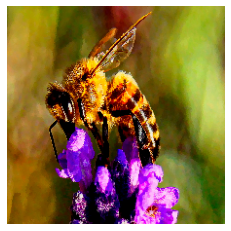

In [7]:
img, scaled_img = load_img(data_path)
plt.imshow(img)
plt.axis('off')

In [8]:
sorted_classes = np.argsort(model.model.predict([scaled_img]))[0][::-1]
print('\n'.join(['{:4} {}'.format(c, class_name(c)) for c in sorted_classes[:10]]))

2021-12-15 10:28:53.232834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 309 bee
 946 cardoon
 308 fly
 319 dragonfly
  74 garden_spider
 321 admiral
 324 cabbage_butterfly
 318 lacewing
 815 spider_web
 323 monarch


## Explainable AI with DIANNA

In [9]:
from dianna.methods import RISE

In [ ]:
explainer = RISE(n_masks=1000, feature_res=8, p_keep=.5)
heatmaps = explainer.explain_image(model.run_on_batch, scaled_img)

Explaining:  30%|█████████▌                      | 3/10 [00:12<00:27,  3.96s/it]

For each class (1000 in this case), an explanation with a shape equal to the input image is generated.

In [ ]:
print(heatmaps.shape)

The explanations can be considered images and can be plotted with e.g. `matplotlib`.  
DIANNA also includes visualization tools.

In [ ]:
from dianna.visualization import plot_image

In [ ]:
for current_class_id in sorted_classes[:5]:
    plot_image(heatmaps[current_class_id], original_data=image.img_to_array(img)/255., heatmap_cmap='jet', show_plot=False)
    plt.title(f'Explanation for `{class_name(current_class_id)}`')
    plt.axis('off')

Note that in these plots, red means important and blue means unimportant.

If we want, we can investigate the internals of the explainable AI method. In the case of RISE, it generated random masks. We can look at these masks too see what parts of the image are masked.

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(explainer.masks[idx], cmap='gray')
    ax.axis('off')